In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

In [2]:
# 加载和处理数据
code = "code_embedding.json"
ir = "ir_embedding.json"
cfg = "cfg_embedding.json"
dynamic = "dynamic.json"

code_data = pd.read_json(code, orient="records", lines=True)
ir_data = pd.read_json(ir, orient="records", lines=True)
cfg_data = pd.read_json(cfg, orient="records", lines=True)
dynamic_data = pd.read_json(dynamic, orient="records", lines=True)

In [3]:
# 提取 code_embedding
code_embedding = np.array(code_data['embedding'].tolist())
ir_embedding = np.array(ir_data['embedding'].tolist())

# # 创建 StandardScaler 对象
# minmax_scaler = MinMaxScaler()

# # 对每个样本的768维嵌入向量进行标准化
# code_embedding_scaled = minmax_scaler.fit_transform(code_embedding)  # 对code嵌入进行标准化
# ir_embedding_scaled = minmax_scaler.fit_transform(ir_embedding)  # 对ir嵌入进行标准化

code_embedding.shape,ir_embedding.shape

((17, 768), (17, 300))

In [4]:
dynamic_features = dynamic_data[['L1MemoryBusy', 'performance', 'L1MemoryStalled', 'NI', 'block_x', 'block_y']].values
# dynamic_features = dynamic_data[['time','L2CacheHit','NI', 'block_x', 'block_y']].values

# 对跨度较大的特征进行对数变换
dynamic_features[:] = np.log1p(dynamic_features[:])

# 归一化
# minmax_scaler = MinMaxScaler()
# dynamic_features = minmax_scaler.fit_transform(dynamic_features)

# 转为 PyTorch 张量
dynamic_features = torch.tensor(dynamic_features, dtype=torch.float)

print(dynamic_features.shape)

labels = dynamic_data[['time', 'L2CacheHit']].values
labels[:] = np.log1p(labels[:])

# 归一化
# minmax_scaler = MinMaxScaler()
# labels = minmax_scaler.fit_transform(labels)

# 转为 PyTorch 张量
labels = torch.tensor(labels, dtype=torch.float)
print(labels.shape)

torch.Size([909, 6])
torch.Size([909, 2])


In [5]:
# 提取cfg_embedding
# 转换图数据（CFG）
graph_data_list = []
for _, row in cfg_data.iterrows():
    # 处理 node_embeddings
    x = torch.tensor(row['node_embeddings'], dtype=torch.float)
    if len(x.shape) > 2:
        x = x.view(-1, x.shape[-1])  # 展开到 (num_nodes, embedding_dim)

    # 处理 edge_index
    edge_index = torch.tensor(row['edge_index'], dtype=torch.long)
    if len(edge_index.shape) > 2:
        edge_index = edge_index.view(2, -1)  # 展开为二维
    elif edge_index.shape[0] != 2:
        edge_index = edge_index.t()  # 转置到 (2, num_edges)

    data = Data(x=x, edge_index=edge_index)
    graph_data_list.append(data)


# 将 code_embedding 和 graph_data_list 和 dynamic_features 和 labels打包
combined_data = list(zip(code_embedding, graph_data_list, dynamic_features,ir_embedding,labels))

code_embedding.shape,dynamic_features.shape,ir_embedding.shape,labels.shape

((17, 768), torch.Size([909, 6]), (17, 300), torch.Size([909, 2]))

In [6]:
class MultiModalDataset:
    def __init__(self, code_embedding, graph_data_list, dynamic_features,ir_embedding, labels):
        self.code_embedding = code_embedding
        self.graph_data_list = graph_data_list
        self.dynamic_features = dynamic_features
        self.ir_embedding = ir_embedding
        self.labels = labels

    def __len__(self):
        return len(self.code_embedding)

    def __getitem__(self, idx):
        code_data = torch.tensor(self.code_embedding[idx], dtype=torch.float)
        graph_data = self.graph_data_list[idx]
        dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)
        ir_data = torch.tensor(self.ir_embedding[idx], dtype=torch.float)
        label = self.labels[idx]
        
        return code_data, dynamic_data, graph_data, ir_data, label


# 划分数据集，按照 7:3 的比例进行划分
train_indices, test_indices = train_test_split(np.arange(len(code_embedding)), test_size=0.3, random_state=42)

# 根据划分的索引创建训练集和测试集
train_code_embeddings = code_embedding[train_indices]
test_code_embeddings = code_embedding[test_indices]
train_dynamic_features = dynamic_features[train_indices]
test_dynamic_features = dynamic_features[test_indices]
train_ir_embeddings = ir_embedding[train_indices]
test_ir_embeddings = ir_embedding[test_indices]
train_labels = labels[train_indices]
test_labels = labels[test_indices]

# 图数据处理
train_graph_data = [graph_data_list[i] for i in train_indices]
test_graph_data = [graph_data_list[i] for i in test_indices]

# 创建数据集
train_dataset = MultiModalDataset(train_code_embeddings, train_graph_data, train_dynamic_features, train_ir_embeddings, train_labels)
test_dataset = MultiModalDataset(test_code_embeddings, test_graph_data, test_dynamic_features, test_ir_embeddings, test_labels)

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_294903/1866840552.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


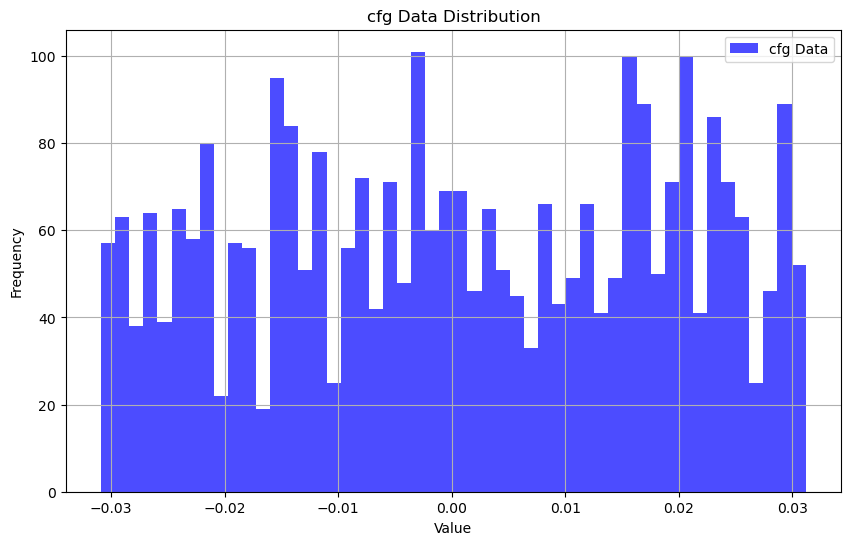

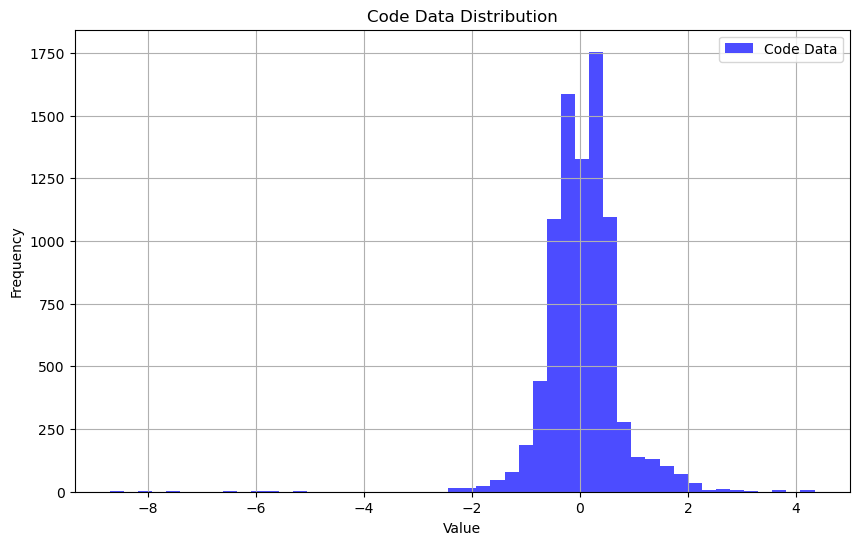

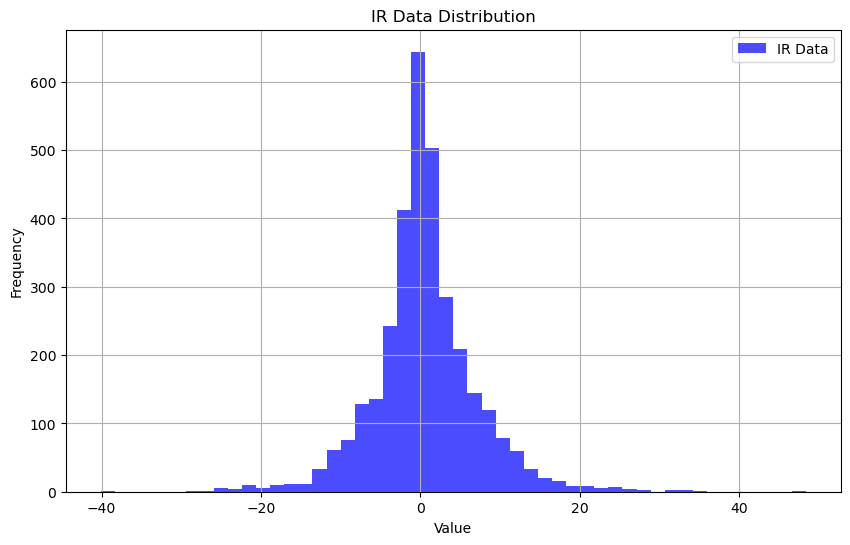

/tmp/ipykernel_294903/2495359692.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


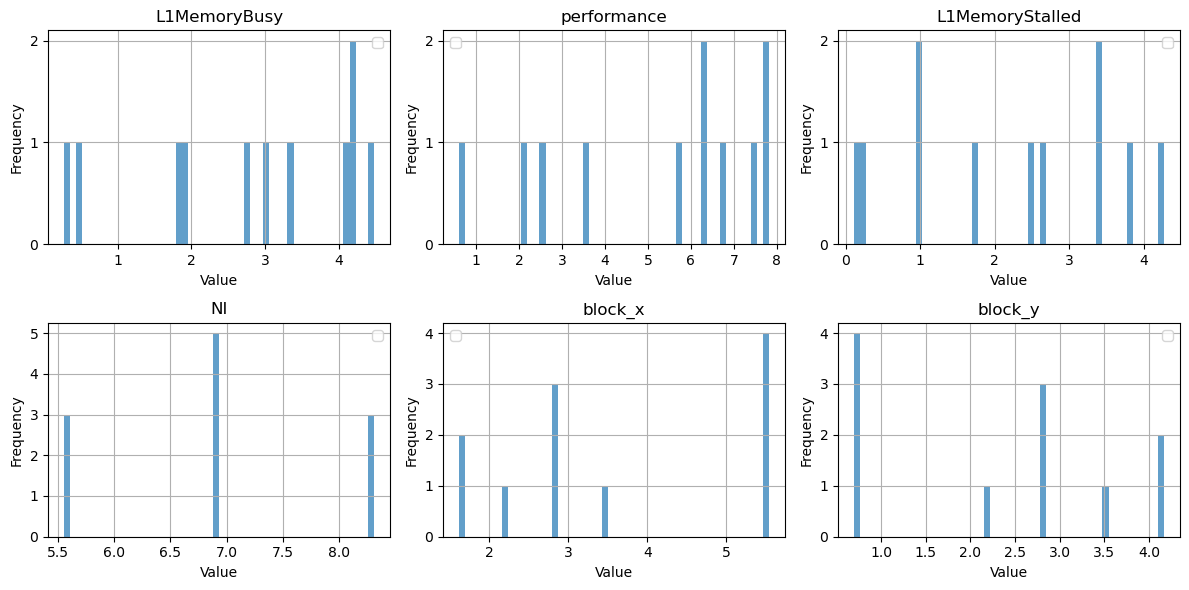

/tmp/ipykernel_294903/2495359692.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


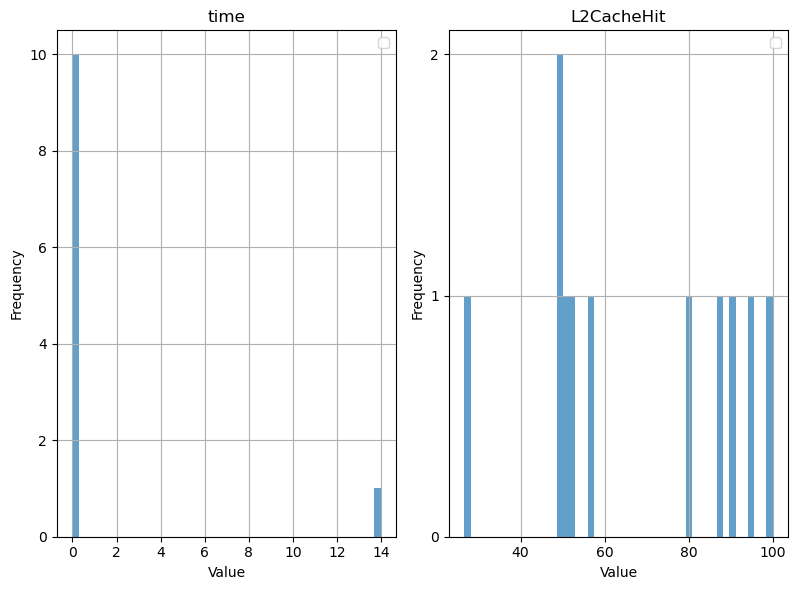

In [43]:
import matplotlib.pyplot as plt

# 取出一个批次的数据
code_data, dynamic_data, graph_data, ir_data, labels = next(iter(train_loader))

# 绘制 graph 数据的分布
plt.figure(figsize=(10, 6))
plt.hist(graph_data.x.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue', label='cfg Data')
plt.title("cfg Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# 绘制 Code 数据的分布
plt.figure(figsize=(10, 6))
plt.hist(code_data.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue', label='Code Data')
plt.title("Code Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# 绘制 ir 数据的分布
plt.figure(figsize=(10, 6))
plt.hist(ir_data.cpu().numpy().flatten(), bins=50, alpha=0.7, color='blue', label='IR Data')
plt.title("IR Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

feature_names=['L1MemoryBusy', 'performance', 'L1MemoryStalled', 'NI', 'block_x', 'block_y']
# dynamic_features_log = torch.log1p(dynamic_data).numpy()

# minmax_scaler = MinMaxScaler()
# dynamic_features_log = minmax_scaler.fit_transform(dynamic_features_log)

# 动态调整子图布局
n_features = dynamic_data.shape[1]
n_rows = (n_features + 2) // 3  # 自动计算行数，4 列布局

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(n_rows, 3, i + 1)  # 动态设置子图位置
    plt.hist(dynamic_data[:, i], bins=50, alpha=0.7)
    plt.title(feature_names[i])
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()

    # Set y-axis to show integer values
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.legend()
plt.tight_layout()
plt.show()

feature_names=['time', 'L2CacheHit']
# labels_log = torch.log1p(labels).numpy()

# minmax_scaler = MinMaxScaler()
# labels_log = minmax_scaler.fit_transform(labels_log)

# 动态调整子图布局
n_features = labels.shape[1]
n_rows = (n_features + 2) // 3  # 自动计算行数，4 列布局

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(n_rows, 3, i + 1)  # 动态设置子图位置
    plt.hist(labels[:, i], bins=50, alpha=0.7)
    plt.title(feature_names[i])
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid()

    # Set y-axis to show integer values
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.legend()
plt.tight_layout()
plt.show()

In [99]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        # 确保 query, key, value 的最后一维是 embed_dim
        assert query.size(-1) == key.size(-1) == value.size(-1), "query, key, and value must have the same last dimension"

        # query, key, value: [batch_size, seq_len, embed_dim]
        attn_output, _ = self.attention(query, key, value)
        return self.norm(attn_output + query)  # Add & Norm


class AblationModelWithWeights(nn.Module):
    def __init__(self, 
                 code_input_dim, 
                 dynamic_input_dim, 
                 gcn_hidden_dim, 
                 gcn_output_dim, 
                 ir_input_dim,  
                 embed_dim,
                 use_code=True, 
                 use_dynamic=True, 
                 use_graph=True,
                 use_ir=True):
        super(AblationModelWithWeights, self).__init__()

        # 是否使用各分支
        self.use_code = use_code
        self.use_dynamic = use_dynamic
        self.use_graph = use_graph
        self.use_ir = use_ir  

        # Code Embedding 分支
        if self.use_code:
            self.code_branch = nn.Sequential(
                nn.Linear(code_input_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, embed_dim)
            )

        # IR Embedding 分支
        if self.use_ir:
            self.ir_branch = nn.Sequential(
                nn.Linear(ir_input_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, embed_dim)
            )

        # CFG Embedding 分支（假设已存在配置或与IR/Code共享相似结构）
        if self.use_graph:
            self.gcn1 = GCNConv(32, gcn_hidden_dim)
            self.bn1 = nn.BatchNorm1d(gcn_hidden_dim)
            self.gcn2 = GCNConv(gcn_hidden_dim, gcn_output_dim)
            self.bn2 = nn.BatchNorm1d(gcn_output_dim)

        # dynamic 数据分支
        if self.use_dynamic:
            self.dynamic_branch = nn.Sequential(
                nn.Linear(dynamic_input_dim, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, embed_dim),
                nn.ReLU()
            )

        # 交叉注意力模块
        self.cross_attention_1 = CrossAttention(embed_dim)
        self.cross_attention_2 = CrossAttention(embed_dim)

        # 融合层
        self.fusion_layer = nn.Sequential(
            nn.Linear(
                (embed_dim if self.use_code else 0) +
                (embed_dim if self.use_dynamic else 0) +
                (embed_dim if self.use_graph else 0) +
                (embed_dim if self.use_ir else 0),
                128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 输出2个标签
        )

    def forward(self, code_data, dynamic_data, graph_data, ir_data):
        fusion_input = []

        # Code Embedding 分支
        if self.use_code:
            code_out = self.code_branch(code_data)  
            fusion_input.append(code_out)

        # IR Embedding 分支
        if self.use_ir:
            ir_out = self.ir_branch(ir_data)  
            fusion_input.append(ir_out)

        # CFG Embedding 分支
        if self.use_graph:
            x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
            x = F.relu(self.bn1(self.gcn1(x, edge_index)))
            x = F.relu(self.bn2(self.gcn2(x, edge_index)))
            x = global_mean_pool(x, batch)  # [batch_size, gcn_output_dim]
            fusion_input.append(x)

        # 动态数据分支
        if self.use_dynamic:
            dynamic_out = self.dynamic_branch(dynamic_data)  
            fusion_input.append(dynamic_out)

        # 如果没有启用任何分支，直接抛出错误
        if len(fusion_input) == 0:
            raise ValueError("At least one of 'use_code', 'use_dynamic', 'use_graph', or 'use_ir' must be True.")

        # 简单拼接所有模态的输出
        fusion_output = torch.cat(fusion_input, dim=1)  # 将所有模态拼接在一起

        # 最终融合层
        out = self.fusion_layer(fusion_output)  

        return out


In [7]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=4, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        # 确保 query, key, value 的最后一维是 embed_dim
        assert query.size(-1) == key.size(-1) == value.size(-1), "query, key, and value must have the same last dimension"

        # query, key, value: [batch_size, seq_len, embed_dim]
        query = query.transpose(0, 1)  # 转换为 [seq_len, batch_size, embed_dim]
        key = key.transpose(0, 1)
        value = value.transpose(0, 1)

        # query, key, value: [batch_size, seq_len, embed_dim]
        attn_output, _ = self.attention(query, key, value)
        return self.norm(attn_output.transpose(0, 1) + query)  # Add & Norm


class AblationModelWithWeights(nn.Module):
    def __init__(self, 
                 code_input_dim, 
                 dynamic_input_dim, 
                 gcn_hidden_dim, 
                 gcn_output_dim, 
                 ir_input_dim,  
                 embed_dim,
                 use_code=True, 
                 use_dynamic=True, 
                 use_graph=True,
                 use_ir=True):
        super(AblationModelWithWeights, self).__init__()

        # 是否使用各分支
        self.use_code = use_code
        self.use_dynamic = use_dynamic
        self.use_graph = use_graph
        self.use_ir = use_ir  

        # Code Embedding 分支
        if self.use_code:
            self.code_branch = nn.Sequential(
                nn.Linear(code_input_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, embed_dim)
            )

        # IR Embedding 分支
        if self.use_ir:
            self.ir_branch = nn.Sequential(
                nn.Linear(ir_input_dim, 256),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, embed_dim)
            )

        # CFG Embedding 分支（假设已存在配置或与IR/Code共享相似结构）
        if self.use_graph:
            self.gcn1 = GCNConv(32, gcn_hidden_dim)
            self.bn1 = nn.BatchNorm1d(gcn_hidden_dim)
            self.gcn2 = GCNConv(gcn_hidden_dim, gcn_output_dim)
            self.bn2 = nn.BatchNorm1d(gcn_output_dim)

        # dynamic 数据分支
        if self.use_dynamic:
            self.dynamic_branch = nn.Sequential(
                nn.Linear(dynamic_input_dim, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, embed_dim),
                nn.ReLU()
            )

        # 交叉注意力模块
        self.cross_attention_1 = CrossAttention(embed_dim)
        self.cross_attention_2 = CrossAttention(embed_dim)

        # 融合层
        self.fusion_layer = nn.Sequential(
            nn.Linear(embed_dim + embed_dim, 128),  # 输出维度是256
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 输出2个标签
        )

    def forward(self, code_data, dynamic_data, graph_data, ir_data):
        fusion_input = []

        # Code Embedding 分支
        if self.use_code:
            code_out = self.code_branch(code_data)  
            fusion_input.append(code_out)

        # IR Embedding 分支
        if self.use_ir:
            ir_out = self.ir_branch(ir_data)  
            fusion_input.append(ir_out)

        # CFG Embedding 分支
        if self.use_graph:
            x, edge_index, batch = graph_data.x, graph_data.edge_index, graph_data.batch
            x = F.relu(self.bn1(self.gcn1(x, edge_index)))
            x = F.relu(self.bn2(self.gcn2(x, edge_index)))
            x = global_mean_pool(x, batch)  # [batch_size, gcn_output_dim]
            x = F.relu(self.bn2(self.gcn2(x, edge_index)))
            fusion_input.append(x)

        # 动态数据分支
        if self.use_dynamic:
            dynamic_out = self.dynamic_branch(dynamic_data)  
            fusion_input.append(dynamic_out)

        # 如果没有启用任何分支，直接抛出错误
        if len(fusion_input) == 0:
            raise ValueError("At least one of 'use_code', 'use_dynamic', 'use_graph', or 'use_ir' must be True.")

        # 交叉注意力处理 - 先对 code, ir 和 cfg 进行两两融合
        if self.use_code and self.use_ir and self.use_graph:
            code_ir_fused = self.cross_attention_1(code_out, ir_out, ir_out)  # code 和 ir 融合
            code_ir_cfg_fused = self.cross_attention_2(code_ir_fused, x, x)  # 上一步的结果与 cfg 融合
            fused = code_ir_cfg_fused
        elif self.use_code and self.use_ir:
            fused = self.cross_attention_1(code_out, ir_out, ir_out)  # code 和 ir 融合
        elif self.use_code and self.use_graph:
            fused = self.cross_attention_1(code_out, x, x)  # code 和 cfg 融合
        else:
            fused = code_out  # 只有 code

        # QKV 融合（再通过交叉注意力模块将其融合成一个256维度的表示）
        fused_qkv = self.cross_attention_2(fused, fused, fused)  # 将融合后的表示再次进行 QKV 融合
        
        # 拼接 QKV 融合结果与 dynamic 数据
        fusion_output = torch.cat([fused_qkv, dynamic_out], dim=1)  # 按照第1维（seq_len维度）拼接

        # 最终融合层
        out = self.fusion_layer(fusion_output)  

        return out


In [8]:
# 模型训练
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 配置不同的消融实验
configs = [
    {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir':True},  # 全部启用（Baseline）
    {'use_code': False, 'use_dynamic': True, 'use_graph': True, 'use_ir':True},  # 去掉 Code 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir':False},  # 去掉 ir 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': False, 'use_ir':True},  # 去掉 cfg 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': True, 'use_ir':True},  # 只有dynamic 分支
]

# 训练参数
epochs = 250
batch_size = 32
loss_history_all = {}

for config in configs:
    print(f"\nTraining with config: {config}\n")
    
    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768, 
        dynamic_input_dim=6, 
        ir_input_dim=300,
        gcn_hidden_dim=128, 
        gcn_output_dim=64, 
        embed_dim=64,
        **config
    ).to(device)

    # 损失函数和优化器
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    loss_history = []

    # 开始训练
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for code_batch, graph_batch, dynamic_batch, ir_batch, labels in train_loader:
            
            # 加载到设备
            dynamic_data = dynamic_batch.to(device)
            graph_data = graph_batch.to(device)
            code_data = code_batch.to(device)
            ir_data = ir_batch.to(device)
            labels = labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            outputs = model(code_data, graph_data, dynamic_data, ir_data)

            # 计算损失
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_loss += loss.item()

        scheduler.step()
        epoch_loss = total_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    loss_history_all[str(config)] = loss_history

    # 保存模型
    model_save_path = f"model/model_{str(config)}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# 绘制训练曲线
for config, history in loss_history_all.items():
    plt.plot(range(1, epochs + 1), history, label=f"Config: {config}")

plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()



Training with config: {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': True}



/tmp/ipykernel_475422/1866840552.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [12,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [14,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [15,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [16,0,0] Assertion

RuntimeError: mat1 and mat2 shapes cannot be multiplied (11x64 and 128x64)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def test_model(config, model_path, test_loader, device):

    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768, 
        dynamic_input_dim=6, 
        ir_input_dim=300,
        gcn_hidden_dim=128, 
        gcn_output_dim=64, 
        embed_dim=64,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, graph_batch, dynamic_batch, ir_batch, labels in test_loader:
            
            # 加载到设备
            dynamic_data = dynamic_batch.to(device)
            graph_data = graph_batch.to(device)
            code_data = code_batch.to(device)
            ir_data = ir_batch.to(device)
            labels = labels.to(device)

            outputs = model(code_data, graph_data, dynamic_data, ir_data)

            # 收集预测值和真实值
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有的预测值和真实值
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")

    all_predictions = np.exp(all_predictions)  # 反变换回原始尺度
    all_labels = np.exp(all_labels)

    # 计算误差指标
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_predictions)

    # 计算 MAPE
    mape = np.mean(np.abs((all_labels - all_predictions) / all_labels)) * 100  # MAPE 计算公式
    # epsilon = 1e-6
    # mape = np.mean([abs((tv - pv) / (tv + epsilon)) * 100 for tv, pv in zip(true_values, predicted_values) if abs(tv) > epsilon])

    print(f"Config: {config}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

    return {
        "config": config,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mape": mape  # 返回 MAPE
    }

# 配置不同的消融实验
configs = [
    {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': True},  # 全部启用（Baseline）
    {'use_code': False, 'use_dynamic': True, 'use_graph': True, 'use_ir': True},  # 去掉 Code 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': False},  # 去掉 ir 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': False, 'use_ir': True},  # 去掉 cfg 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': True, 'use_ir': True}  # 只有dynamic 分支
]

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model/model_{str(config)}.pth"  # 模型路径
    result = test_model(config, model_load_path, test_loader, device)
    results.append(result)

# 打印最终结果汇总
print("\nFinal Results Summary:")
for result in results:
    print(f"Config: {result['config']}")
    print(f"MAE: {result['mae']:.4f}, MSE: {result['mse']:.4f}, RMSE: {result['rmse']:.4f}, R²: {result['r2']:.4f}, MAPE: {result['mape']:.4f}")
    print("-" * 50)

# 提取指标
config_labels = [str(res["config"]) for res in results]
mae_values = [res["mae"] for res in results]
mse_values = [res["mse"] for res in results]
rmse_values = [res["rmse"] for res in results]
r2_values = [res["r2"] for res in results]
mape_values = [res["mape"] for res in results]  # MAPE

# 文件名
output_file = "ablation_model_results_with_mape.csv"

# 保存到 CSV 文件
import csv
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # 写入表头
    writer.writerow(["Config", "MAE", "MSE", "RMSE", "R²", "MAPE"])
    # 写入数据
    for i in range(len(config_labels)):
        writer.writerow([config_labels[i], mae_values[i], mse_values[i], rmse_values[i], r2_values[i], mape_values[i]])

print(f"Results saved to {output_file}")

# 绘制所有曲线到一个图中
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(config_labels, mae_values, marker='o', label="MAE", color='blue')
plt.plot(config_labels, mse_values, marker='o', label="MSE", color='orange')
plt.plot(config_labels, rmse_values, marker='o', label="RMSE", color='green')
plt.plot(config_labels, r2_values, marker='o', label="R²", color='red')
plt.plot(config_labels, mape_values, marker='o', label="MAPE", color='purple')

plt.title("Comparison of Error Metrics Across Configs")
plt.xlabel("Configs")
plt.ylabel("Metrics")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



Testing with config: {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': True}
Model loaded from model/model_{'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': True}.pth
Predictions shape: (6, 2), Labels shape: (6, 2)
Config: {'use_code': True, 'use_dynamic': True, 'use_graph': True, 'use_ir': True}
Mean Absolute Error (MAE): 19.1281
Mean Squared Error (MSE): 793.9218
Root Mean Squared Error (RMSE): 28.1766
R² Score: -8.1597
Mean Absolute Percentage Error (MAPE): 26.6145

Testing with config: {'use_code': False, 'use_dynamic': True, 'use_graph': True, 'use_ir': True}


/tmp/ipykernel_365679/1866840552.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


RuntimeError: Error(s) in loading state_dict for AblationModelWithWeights:
	size mismatch for fusion_layer.0.weight: copying a param with shape torch.Size([128, 192]) from checkpoint, the shape in current model is torch.Size([128, 128]).

消融实验

In [85]:
import torch
import matplotlib.pyplot as plt

# 加载测试数据到 DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 加载训练好的模型
model_load_path = "fusion_model_attention.pth"
model = FusionModelWithAttention(
    code_input_dim=768, 
    dynamic_input_dim=8, 
    ir_input_dim=300,
    gcn_hidden_dim=32, 
    gcn_output_dim=16, 
    embed_dim=32
).to(device)

model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()
print(f"Model loaded from {model_load_path}")

# 初始化存储预测值和真实值的列表
all_predictions = []
all_labels = []

# 开始测试
with torch.no_grad():
    for code_batch, graph_batch, dynamic_batch, ir_batch, labels in train_loader:
            
        # 加载到设备
        dynamic_data = dynamic_batch.to(device)
        graph_data = graph_batch.to(device)
        code_data = code_batch.to(device)
        ir_data = ir_batch.to(device)
        labels = labels.to(device)
    


        # 前向传播得到预测值
        outputs = model(code_data, graph_data, dynamic_data, ir_data)

        # 收集预测值和真实值
        all_predictions.append(outputs.cpu())
        all_labels.append(labels.cpu())



NameError: name 'FusionModelWithAttention' is not defined

只输入code测试数据的预测结果

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def test_model_by_category(config, model_path, test_loader, device, use_code_only=True):
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            # labels = labels.to(device)

            # 如果只使用 code 模态
            if use_code_only:
                # 仅使用 code 数据，填充其他模态为零
                code_data = code_batch.to(device)
                dynamic_data = torch.zeros(code_data.size(0), 16).to(device)  # 填充 dynamic 数据为 (batch_size, 16)
                graph_data = Data(
                    x=torch.zeros(code_data.size(0), 32).to(device),  # 填充节点特征为 32
                    edge_index=torch.zeros(2, code_data.size(0)).to(device).long(),  # 填充边索引
                    batch=torch.zeros(code_data.size(0), dtype=torch.long).to(device)  # 填充批次索引
                )
            else:
                # 使用所有模态
                if config.get("use_code", True):
                    code_data = code_batch.to(device)
                else:
                    code_data = torch.zeros_like(code_batch).to(device)

                if config.get("use_dynamic", True):
                    dynamic_data = dynamic_batch.to(device)
                else:
                    dynamic_data = torch.zeros_like(dynamic_batch).to(device)

                if config.get("use_graph", True):
                    graph_data = graph_batch.to(device)
                else:
                    graph_data = type(graph_batch)(
                        x=torch.zeros_like(graph_batch.x).to(device),
                        edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                        batch=torch.zeros_like(graph_batch.batch).to(device),
                    )


            # 模型推理
            outputs = model(code_data, dynamic_data, graph_data)
            # print(outputs)
            all_predictions.append(outputs.cpu())
            print(labels.cpu())
            # all_labels.append(labels.cpu())

    # 将所有预测结果和标签合并
    # all_predictions = torch.cat(all_predictions, dim=0).numpy()
    # all_labels = torch.cat(all_labels, dim=0).numpy()

    # print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")



# 配置不同的消融实验
configs = [
    # {'use_code': True, 'use_dynamic': True, 'use_graph': True},  # 全部启用（Baseline）
    # {'use_code': False, 'use_dynamic': True, 'use_graph': True},  # 去掉 Code 分支
    # {'use_code': True, 'use_dynamic': False, 'use_graph': True},  # 去掉 dynamic 分支
    # {'use_code': True, 'use_dynamic': True, 'use_graph': False},  # 去掉 Graph 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': False},  # 去掉 Graph 分支
]

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model/model_{str(config)}.pth"
    test_model_by_category(config, model_load_path, test_loader, device)


Testing with config: {'use_code': True, 'use_tabular': False, 'use_graph': False}
Model loaded from model/model_{'use_code': True, 'use_tabular': False, 'use_graph': False}.pth


/tmp/ipykernel_33312/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


tensor([[2.1853e-05, 3.1995e-02, 6.3831e-01, 2.0325e-03],
        [2.1853e-05, 3.1995e-02, 6.3805e-01, 2.0344e-03],
        [1.1523e-05, 3.1995e-02, 6.3846e-01, 4.0736e-03],
        [2.5164e-05, 3.1995e-02, 6.3805e-01, 2.0344e-03],
        [1.2053e-05, 3.1995e-02, 6.3831e-01, 4.0698e-03],
        [1.1655e-05, 3.1995e-02, 6.4082e-01, 4.0775e-03],
        [2.3177e-05, 3.1995e-02, 6.3946e-01, 2.0325e-03],
        [5.8278e-06, 1.0746e-01, 4.6558e-01, 0.0000e+00],
        [1.1920e-05, 6.4594e-02, 3.9799e-02, 0.0000e+00],
        [1.2318e-05, 3.1995e-02, 6.3779e-01, 4.0813e-03],
        [2.4369e-05, 3.2297e-02, 6.3765e-01, 2.0335e-03],
        [2.5826e-05, 3.2297e-02, 6.3743e-01, 2.0335e-03],
        [6.6225e-06, 2.4147e-02, 7.5619e-01, 8.0376e-03],
        [2.3045e-05, 3.1995e-02, 6.4073e-01, 2.0325e-03],
        [2.1720e-05, 3.1995e-02, 6.3946e-01, 2.0325e-03],
        [1.1523e-05, 3.1995e-02, 6.3980e-01, 4.0736e-03],
        [2.1985e-05, 7.7090e-01, 3.7666e-02, 0.0000e+00],
        [1.125

只输入code的消融实验

In [16]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def test_model(config, model_path, test_loader, device):
    """
    对单个配置的模型进行测试，并计算误差指标。
    """
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            # 将标签加载到设备
            labels = labels.to(device)
            # Code 模态
            if config.get("use_code", True):
                code_data = code_batch.to(device)
            else:
                code_data = torch.zeros_like(code_batch).to(device)  # 使用零向量代替

            # dynamic 模态
            if config.get("use_dynamic", True):
                dynamic_data = dynamic_batch.to(device)
            else:
                dynamic_data = torch.zeros_like(dynamic_batch).to(device)  # 使用零向量代替

            # Graph 模态
            if config.get("use_graph", True):
                graph_data = graph_batch.to(device)
            else:
                # 使用空图代替 graph 模态
                graph_data = type(graph_batch)(
                    x=torch.zeros_like(graph_batch.x).to(device),
                    edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                    batch=torch.zeros_like(graph_batch.batch).to(device),
                )



            # 前向传播得到预测值
            outputs = model(code_data, dynamic_data, graph_data)

            # 收集预测值和真实值
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有的预测值和真实值
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")

    # 计算误差指标
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_predictions)

    print(f"Config: {config}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {
        "config": config,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
    }

# 配置不同的消融实验
configs = [
    {'use_code': True, 'use_dynamic': True, 'use_graph': True},  # 全部启用（Baseline）
    {'use_code': False, 'use_dynamic': True, 'use_graph': True},  # 去掉 Code 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': True},  # 去掉 dynamic 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': False},  # 去掉 Graph 分支
]

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model_{str(config)}.pth"  # 模型路径
    result = test_model(config, model_load_path, test_loader, device)
    results.append(result)

# 打印最终结果汇总
print("\nFinal Results Summary:")
print("code input only\n")
for result in results:
    print(f"Config: {result['config']}")
    print(f"MAE: {result['mae']:.4f}, MSE: {result['mse']:.4f}, RMSE: {result['rmse']:.4f}, R²: {result['r2']:.4f}")
    print("-" * 50)



Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_33312/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x6 and 16x64)

只输入code测试数据的消融实验

In [15]:
import csv
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def test_model_by_category(config, model_path, test_loader, device, use_code_only=True):
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            labels = labels.to(device)

            # 如果只使用 code 模态
            if use_code_only:
                # 仅使用 code 数据，填充其他模态为零
                code_data = code_batch.to(device)
                dynamic_data = torch.zeros(code_data.size(0), 16).to(device)  # 填充 dynamic 数据为 (batch_size, 16)
                graph_data = Data(
                    x=torch.zeros(code_data.size(0), 32).to(device),  # 填充节点特征为 32
                    edge_index=torch.zeros(2, code_data.size(0)).to(device).long(),  # 填充边索引
                    batch=torch.zeros(code_data.size(0), dtype=torch.long).to(device)  # 填充批次索引
                )
            else:
                # 使用所有模态
                if config.get("use_code", True):
                    code_data = code_batch.to(device)
                else:
                    code_data = torch.zeros_like(code_batch).to(device)

                if config.get("use_dynamic", True):
                    dynamic_data = dynamic_batch.to(device)
                else:
                    dynamic_data = torch.zeros_like(dynamic_batch).to(device)

                if config.get("use_graph", True):
                    graph_data = graph_batch.to(device)
                else:
                    graph_data = type(graph_batch)(
                        x=torch.zeros_like(graph_batch.x).to(device),
                        edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                        batch=torch.zeros_like(graph_batch.batch).to(device),
                    )


            # 模型推理
            outputs = model(code_data, dynamic_data, graph_data)
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # 将所有预测结果和标签合并
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")

    # 存储各类别的结果
    category_metrics = {}
    categories = ['time', 'T_AMAT_s', 'HitRate_L1', 'HitRate_L2']

    # 遍历四个类别
    for i, category in enumerate(categories):
        true_values = all_labels[:, i]
        predicted_values = all_predictions[:, i]

        mae = mean_absolute_error(true_values, predicted_values)
        mse = mean_squared_error(true_values, predicted_values)
        rmse = mse ** 0.5
        r2 = r2_score(true_values, predicted_values)

        epsilon = 1e-6
        mape = np.mean([abs((tv - pv) / (tv + epsilon)) * 100 for tv, pv in zip(true_values, predicted_values) if abs(tv) > epsilon])

        percentage_errors = [min(abs((tv - pv) / (tv + epsilon)) * 100, 100) for tv, pv in zip(true_values, predicted_values)]
        mean_error_percentage = np.mean(percentage_errors)

        percentage_accuracies = [max(100 - pe, 0) for pe in percentage_errors]
        mean_accuracy_percentage = np.mean(percentage_accuracies)

        category_metrics[category] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2,
            "MAPE": mape,
            "Mean Error Percentage": mean_error_percentage,
            "Mean Accuracy Percentage": mean_accuracy_percentage,
        }

    # 打印每个类别的结果
    for category, metrics in category_metrics.items():
        print(f"\nCategory: {category}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"MSE: {metrics['MSE']:.4f}")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"R²: {metrics['R²']:.4f}")
        print(f"MAPE: {metrics['MAPE']:.2f}%")
        print(f"Mean Error Percentage: {metrics['Mean Error Percentage']:.2f}%")
        print(f"Mean Accuracy Percentage: {metrics['Mean Accuracy Percentage']:.2f}%")

    return category_metrics


# 配置不同的消融实验
configs = [
    # {'use_code': True, 'use_dynamic': True, 'use_graph': True},  # 全部启用（Baseline）
    # {'use_code': False, 'use_dynamic': True, 'use_graph': True},  # 去掉 Code 分支
    # {'use_code': True, 'use_dynamic': False, 'use_graph': True},  # 去掉 dynamic 分支
    # {'use_code': True, 'use_dynamic': True, 'use_graph': False},  # 去掉 Graph 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': False},  # 去掉 Graph 分支
]

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model_{str(config)}.pth"
    result = test_model_by_category(config, model_load_path, test_loader, device)
    results.append({"config": config, "category_metrics": result})

# 保存到 CSV 文件
output_file = "result/code_category_metrics_results_kind.csv"
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Config", "Category", "MAE", "MSE", "RMSE", "R²", "MAPE (%)", "Mean Error Percentage (%)", "Mean Accuracy Percentage (%)"])
    for res in results:
        config = res["config"]
        for category, metrics in res["category_metrics"].items():
            writer.writerow([config, category, metrics["MAE"], metrics["MSE"], metrics["RMSE"], metrics["R²"], metrics["MAPE"],
                             metrics["Mean Error Percentage"], metrics["Mean Accuracy Percentage"]])

print(f"Results saved to {output_file}")


Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_33312/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 1 for tensor number 2 in the list.

只输入code的消融实验，包含误差百分比，预测精度

In [12]:
# 对单个配置的模型进行测试，并分别计算四个类别的误差指标
def test_model_by_category(config, model_path, test_loader, device):
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            labels = labels.to(device)
            if config.get("use_code", True):
                code_data = code_batch.to(device)
            else:
                code_data = torch.zeros_like(code_batch).to(device)

            if config.get("use_dynamic", True):
                dynamic_data = dynamic_batch.to(device)
            else:
                dynamic_data = torch.zeros_like(dynamic_batch).to(device)

            if config.get("use_graph", True):
                graph_data = graph_batch.to(device)
            else:
                graph_data = type(graph_batch)(
                    x=torch.zeros_like(graph_batch.x).to(device),
                    edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                    batch=torch.zeros_like(graph_batch.batch).to(device),
                )



            outputs = model(code_data, dynamic_data, graph_data)
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")

    # 存储各类别的结果
    category_metrics = {}
    categories = ['time', 'T_AMAT_s', 'HitRate_L1', 'HitRate_L2']

    # 遍历四个类别
    for i, category in enumerate(categories):
        true_values = all_labels[:, i]
        predicted_values = all_predictions[:, i]

        mae = mean_absolute_error(true_values, predicted_values)
        mse = mean_squared_error(true_values, predicted_values)
        rmse = mse ** 0.5
        r2 = r2_score(true_values, predicted_values)

        epsilon = 1e-6
        mape = np.mean([abs((tv - pv) / (tv + epsilon)) * 100 for tv, pv in zip(true_values, predicted_values) if abs(tv) > epsilon])

        percentage_errors = [min(abs((tv - pv) / (tv + epsilon)) * 100, 100) for tv, pv in zip(true_values, predicted_values)]
        mean_error_percentage = np.mean(percentage_errors)

        percentage_accuracies = [max(100 - pe, 0) for pe in percentage_errors]
        mean_accuracy_percentage = np.mean(percentage_accuracies)

        category_metrics[category] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2,
            "MAPE": mape,
            "Mean Error Percentage": mean_error_percentage,
            "Mean Accuracy Percentage": mean_accuracy_percentage,
        }

    # 打印每个类别的结果
    for category, metrics in category_metrics.items():
        print(f"\nCategory: {category}")
        print(f"MAE: {metrics['MAE']:.4f}")
        print(f"MSE: {metrics['MSE']:.4f}")
        print(f"RMSE: {metrics['RMSE']:.4f}")
        print(f"R²: {metrics['R²']:.4f}")
        print(f"MAPE: {metrics['MAPE']:.2f}%")
        print(f"Mean Error Percentage: {metrics['Mean Error Percentage']:.2f}%")
        print(f"Mean Accuracy Percentage: {metrics['Mean Accuracy Percentage']:.2f}%")

    return category_metrics

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model_{str(config)}.pth"
    result = test_model_by_category(config, model_load_path, test_loader, device)
    results.append({"config": config, "category_metrics": result})

# 保存到 CSV 文件
output_file = "result\category_metrics_results_kind.csv"
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Config", "Category", "MAE", "MSE", "RMSE", "R²", "MAPE (%)", "Mean Error Percentage (%)", "Mean Accuracy Percentage (%)"])
    for res in results:
        config = res["config"]
        for category, metrics in res["category_metrics"].items():
            writer.writerow([config, category, metrics["MAE"], metrics["MSE"], metrics["RMSE"], metrics["R²"], metrics["MAPE"],
                             metrics["Mean Error Percentage"], metrics["Mean Accuracy Percentage"]])

print(f"Results saved to {output_file}")



Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_101602/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)

Category: time
MAE: 0.0045
MSE: 0.0002
RMSE: 0.0150
R²: 0.0396
MAPE: 28166.80%
Mean Error Percentage: 99.80%
Mean Accuracy Percentage: 0.20%

Category: T_AMAT_s
MAE: 0.0160
MSE: 0.0033
RMSE: 0.0570
R²: 0.1559
MAPE: 28.92%
Mean Error Percentage: 26.47%
Mean Accuracy Percentage: 73.53%

Category: HitRate_L1
MAE: 0.0315
MSE: 0.0019
RMSE: 0.0437
R²: 0.9447
MAPE: 20.53%
Mean Error Percentage: 11.24%
Mean Accuracy Percentage: 88.76%

Category: HitRate_L2
MAE: 0.0075
MSE: 0.0005
RMSE: 0.0224
R²: 0.9733
MAPE: 152.26%
Mean Error Percentage: 96.27%
Mean Accuracy Percentage: 3.73%

Testing with config: {'use_code': False, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': False, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_101602/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)

Category: time
MAE: 0.0024
MSE: 0.0002
RMSE: 0.0149
R²: 0.0533
MAPE: 10952.83%
Mean Error Percentage: 99.83%
Mean Accuracy Percentage: 0.17%

Category: T_AMAT_s
MAE: 0.0155
MSE: 0.0033
RMSE: 0.0576
R²: 0.1385
MAPE: 40.69%
Mean Error Percentage: 25.04%
Mean Accuracy Percentage: 74.96%

Category: HitRate_L1
MAE: 0.0304
MSE: 0.0020
RMSE: 0.0442
R²: 0.9436
MAPE: 20.30%
Mean Error Percentage: 12.35%
Mean Accuracy Percentage: 87.65%

Category: HitRate_L2
MAE: 0.0068
MSE: 0.0006
RMSE: 0.0235
R²: 0.9704
MAPE: 247.04%
Mean Error Percentage: 80.47%
Mean Accuracy Percentage: 19.53%

Testing with config: {'use_code': True, 'use_tabular': False, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': False, 'use_graph': True}.pth


/tmp/ipykernel_101602/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)

Category: time
MAE: 0.0032
MSE: 0.0002
RMSE: 0.0149
R²: 0.0475
MAPE: 14922.45%
Mean Error Percentage: 99.87%
Mean Accuracy Percentage: 0.13%

Category: T_AMAT_s
MAE: 0.0219
MSE: 0.0038
RMSE: 0.0620
R²: 0.0038
MAPE: 60.00%
Mean Error Percentage: 49.03%
Mean Accuracy Percentage: 50.97%

Category: HitRate_L1
MAE: 0.1044
MSE: 0.0342
RMSE: 0.1850
R²: 0.0105
MAPE: 143.73%
Mean Error Percentage: 16.79%
Mean Accuracy Percentage: 83.21%

Category: HitRate_L2
MAE: 0.0113
MSE: 0.0049
RMSE: 0.0704
R²: 0.7350
MAPE: 185.82%
Mean Error Percentage: 78.70%
Mean Accuracy Percentage: 21.30%

Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': False}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': False}.pth


/tmp/ipykernel_101602/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)

Category: time
MAE: 0.0127
MSE: 0.0004
RMSE: 0.0195
R²: -0.6279
MAPE: 91402.63%
Mean Error Percentage: 99.88%
Mean Accuracy Percentage: 0.12%

Category: T_AMAT_s
MAE: 0.0208
MSE: 0.0033
RMSE: 0.0576
R²: 0.1392
MAPE: 53.63%
Mean Error Percentage: 42.57%
Mean Accuracy Percentage: 57.43%

Category: HitRate_L1
MAE: 0.0284
MSE: 0.0021
RMSE: 0.0458
R²: 0.9394
MAPE: 17.29%
Mean Error Percentage: 10.41%
Mean Accuracy Percentage: 89.59%

Category: HitRate_L2
MAE: 0.0045
MSE: 0.0003
RMSE: 0.0175
R²: 0.9836
MAPE: 88.95%
Mean Error Percentage: 43.96%
Mean Accuracy Percentage: 56.04%


NameError: name 'csv' is not defined

只输入code的消融实验，包含评价指标图


Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)
Config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Mean Absolute Error (MAE): 0.0149
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0384
R² Score: 0.5283

Testing with config: {'use_code': False, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': False, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)
Config: {'use_code': False, 'use_tabular': True, 'use_graph': True}
Mean Absolute Error (MAE): 0.0138
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0389
R² Score: 0.5264

Testing with config: {'use_code': True, 'use_tabular': False, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': False, 'use_graph': True}.pth


/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)
Config: {'use_code': True, 'use_tabular': False, 'use_graph': True}
Mean Absolute Error (MAE): 0.0352
Mean Squared Error (MSE): 0.0108
Root Mean Squared Error (RMSE): 0.1040
R² Score: 0.1992

Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': False}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': False}.pth


/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Predictions shape: (10622, 4), Labels shape: (10622, 4)
Config: {'use_code': True, 'use_tabular': True, 'use_graph': False}
Mean Absolute Error (MAE): 0.0166
Mean Squared Error (MSE): 0.0015
Root Mean Squared Error (RMSE): 0.0391
R² Score: 0.3586

Final Results Summary:
Config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
MAE: 0.0149, MSE: 0.0015, RMSE: 0.0384, R²: 0.5283
--------------------------------------------------
Config: {'use_code': False, 'use_tabular': True, 'use_graph': True}
MAE: 0.0138, MSE: 0.0015, RMSE: 0.0389, R²: 0.5264
--------------------------------------------------
Config: {'use_code': True, 'use_tabular': False, 'use_graph': True}
MAE: 0.0352, MSE: 0.0108, RMSE: 0.1040, R²: 0.1992
--------------------------------------------------
Config: {'use_code': True, 'use_tabular': True, 'use_graph': False}
MAE: 0.0166, MSE: 0.0015, RMSE: 0.0391, R²: 0.3586
--------------------------------------------------
Results saved to ablation_model_results.csv


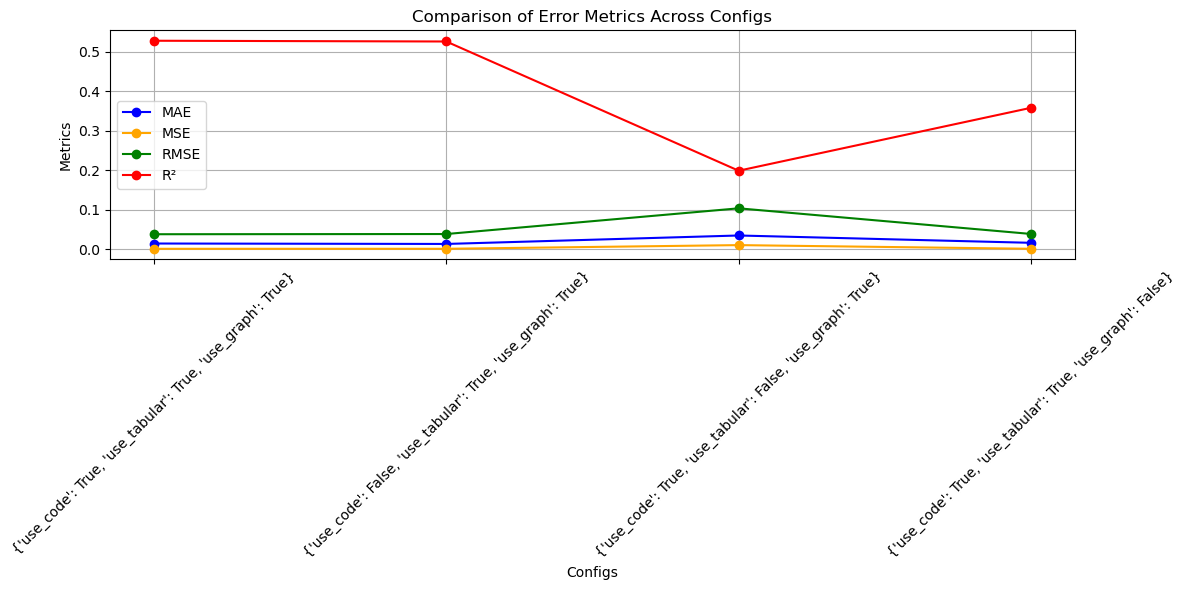

In [51]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import csv

def test_model(config, model_path, test_loader, device):
    """
    对单个配置的模型进行测试，并计算误差指标。
    """
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            # 将标签加载到设备
            labels = labels.to(device)
            # Code 模态
            if config.get("use_code", True):
                code_data = code_batch.to(device)
            else:
                code_data = torch.zeros_like(code_batch).to(device)  # 使用零向量代替

            # dynamic 模态
            if config.get("use_dynamic", True):
                dynamic_data = dynamic_batch.to(device)
            else:
                dynamic_data = torch.zeros_like(dynamic_batch).to(device)  # 使用零向量代替

            # Graph 模态
            if config.get("use_graph", True):
                graph_data = graph_batch.to(device)
            else:
                # 使用空图代替 graph 模态
                graph_data = type(graph_batch)(
                    x=torch.zeros_like(graph_batch.x).to(device),
                    edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                    batch=torch.zeros_like(graph_batch.batch).to(device),
                )

            # 前向传播得到预测值
            outputs = model(code_data, dynamic_data, graph_data)

            # 收集预测值和真实值
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有的预测值和真实值
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")

    # 计算误差指标
    mae = mean_absolute_error(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = mse ** 0.5
    r2 = r2_score(all_labels, all_predictions)

    print(f"Config: {config}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return {
        "config": config,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
    }

# 配置不同的消融实验
configs = [
    {'use_code': True, 'use_dynamic': True, 'use_graph': True},  # 全部启用（Baseline）
    {'use_code': False, 'use_dynamic': True, 'use_graph': True},  # 去掉 Code 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': True},  # 去掉 dynamic 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': False},  # 去掉 Graph 分支
]

# 测试所有配置
results = []
for config in configs:
    model_load_path = f"model_{str(config)}.pth"  # 模型路径
    result = test_model(config, model_load_path, test_loader, device)
    results.append(result)

# 打印最终结果汇总
print("\nFinal Results Summary:")
for result in results:
    print(f"Config: {result['config']}")
    print(f"MAE: {result['mae']:.4f}, MSE: {result['mse']:.4f}, RMSE: {result['rmse']:.4f}, R²: {result['r2']:.4f}")
    print("-" * 50)

# 提取指标
config_labels = [str(res["config"]) for res in results]
mae_values = [res["mae"] for res in results]
mse_values = [res["mse"] for res in results]
rmse_values = [res["rmse"] for res in results]
r2_values = [res["r2"] for res in results]

# 文件名
output_file = "ablation_model_results.csv"

# 保存到 CSV 文件
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # 写入表头
    writer.writerow(["Config", "MAE", "MSE", "RMSE", "R²"])
    # 写入数据
    for i in range(len(config_labels)):
        writer.writerow([config_labels[i], mae_values[i], mse_values[i], rmse_values[i], r2_values[i]])

print(f"Results saved to {output_file}")

# 绘制所有曲线到一个图中
plt.figure(figsize=(12, 6))

plt.plot(config_labels, mae_values, marker='o', label="MAE", color='blue')
plt.plot(config_labels, mse_values, marker='o', label="MSE", color='orange')
plt.plot(config_labels, rmse_values, marker='o', label="RMSE", color='green')
plt.plot(config_labels, r2_values, marker='o', label="R²", color='red')

plt.title("Comparison of Error Metrics Across Configs")
plt.xlabel("Configs")
plt.ylabel("Metrics")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


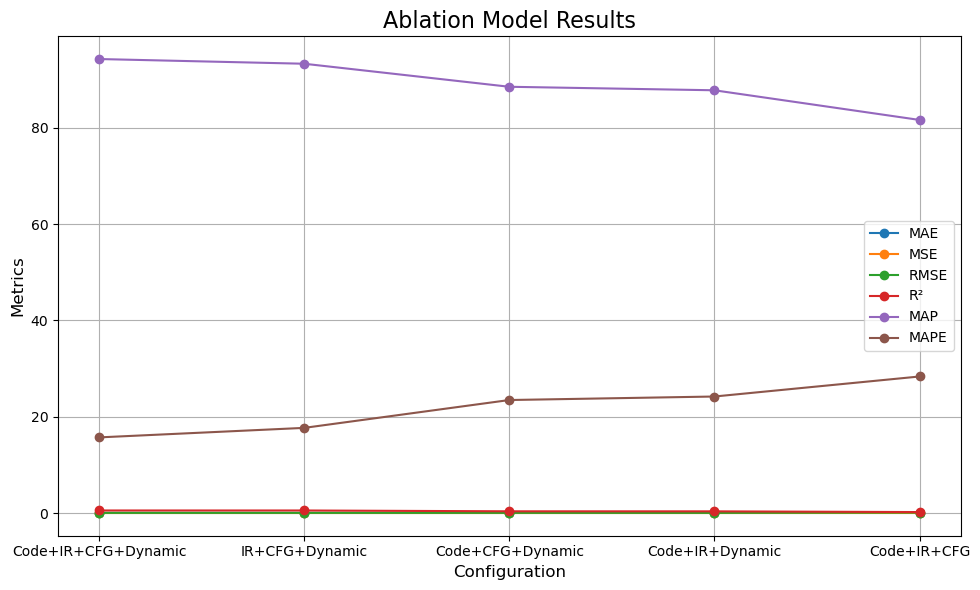

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件
file_path = "ablation_model_results.csv"
df = pd.read_csv(file_path)

# 绘制折线图
plt.figure(figsize=(10, 6))

# 绘制每个指标的曲线
for metric in ["MAE", "MSE", "RMSE", "R²","MAP", "MAPE"]:
    plt.plot(df["Config"], df[metric], marker='o', label=metric)
    
# 图形设置
plt.title("Ablation Model Results", fontsize=16)
plt.xlabel("Configuration", fontsize=12)
plt.ylabel("Metrics", fontsize=12)
plt.xticks(rotation=0, ha='center')  # 将 rotation 设置为 0，使标签水平显示
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("png/Ablation Model Results.png", dpi=300)  # 保存为 PNG 格式，分辨率为 300 DPI
# 显示图形
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/home/pm/performance_modeling/per_model/new_process/png/prediction accuracy.png'

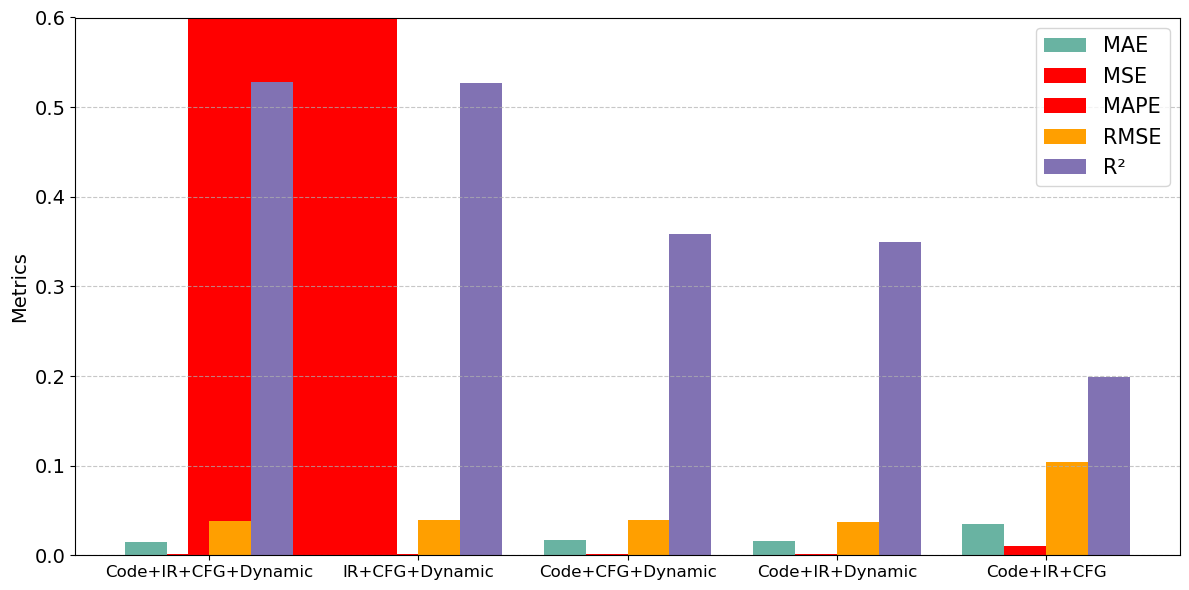

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取 CSV 文件
file_path = "result/ablation_model_results.csv"
df = pd.read_csv(file_path)

# 设置柱状图的参数
bar_width = 0.2  # 每个柱的宽度
x = np.arange(len(df["Config"]))  # 每个配置的 x 轴位置

# 绘制柱状图
plt.figure(figsize=(12, 6))

# 为每个指标绘制柱状图
plt.bar(x - 1.5 * bar_width, df["MAE"], width=bar_width, label="MAE", color="#69b3a2")
plt.bar(x - 0.5 * bar_width, df["MSE"], width=bar_width, label="MSE", color="red")
plt.bar(x - 0.5 * bar_width, df["MAP"], width=bar_width, label="MSE", color="red")
plt.bar(x - 0.5 * bar_width, df["MAPE"], width=bar_width, label="MSE", color="red")
plt.bar(x + 0.5 * bar_width, df["RMSE"], width=bar_width, label="RMSE", color="#ff9f00")
plt.bar(x + 1.5 * bar_width, df["R²"], width=bar_width, label="R²", color="#8172b3")

# 添加配置名称作为 x 轴刻度
plt.xticks(x, df["Config"], rotation=0, ha='center', fontsize=12)  # 将 rotation 设置为 0，使其水平显示
plt.ylim(0, 0.6) 
# 图形设置
plt.ylabel("Metrics", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tick_params(axis='y', labelsize=14)
plt.legend(prop = {'size':15})
plt.tight_layout()
# plt.savefig("png/prediction accuracy.png", dpi=300)  # 保存为 PNG 格式，分辨率为 300 DPI
# 显示图形
plt.show()


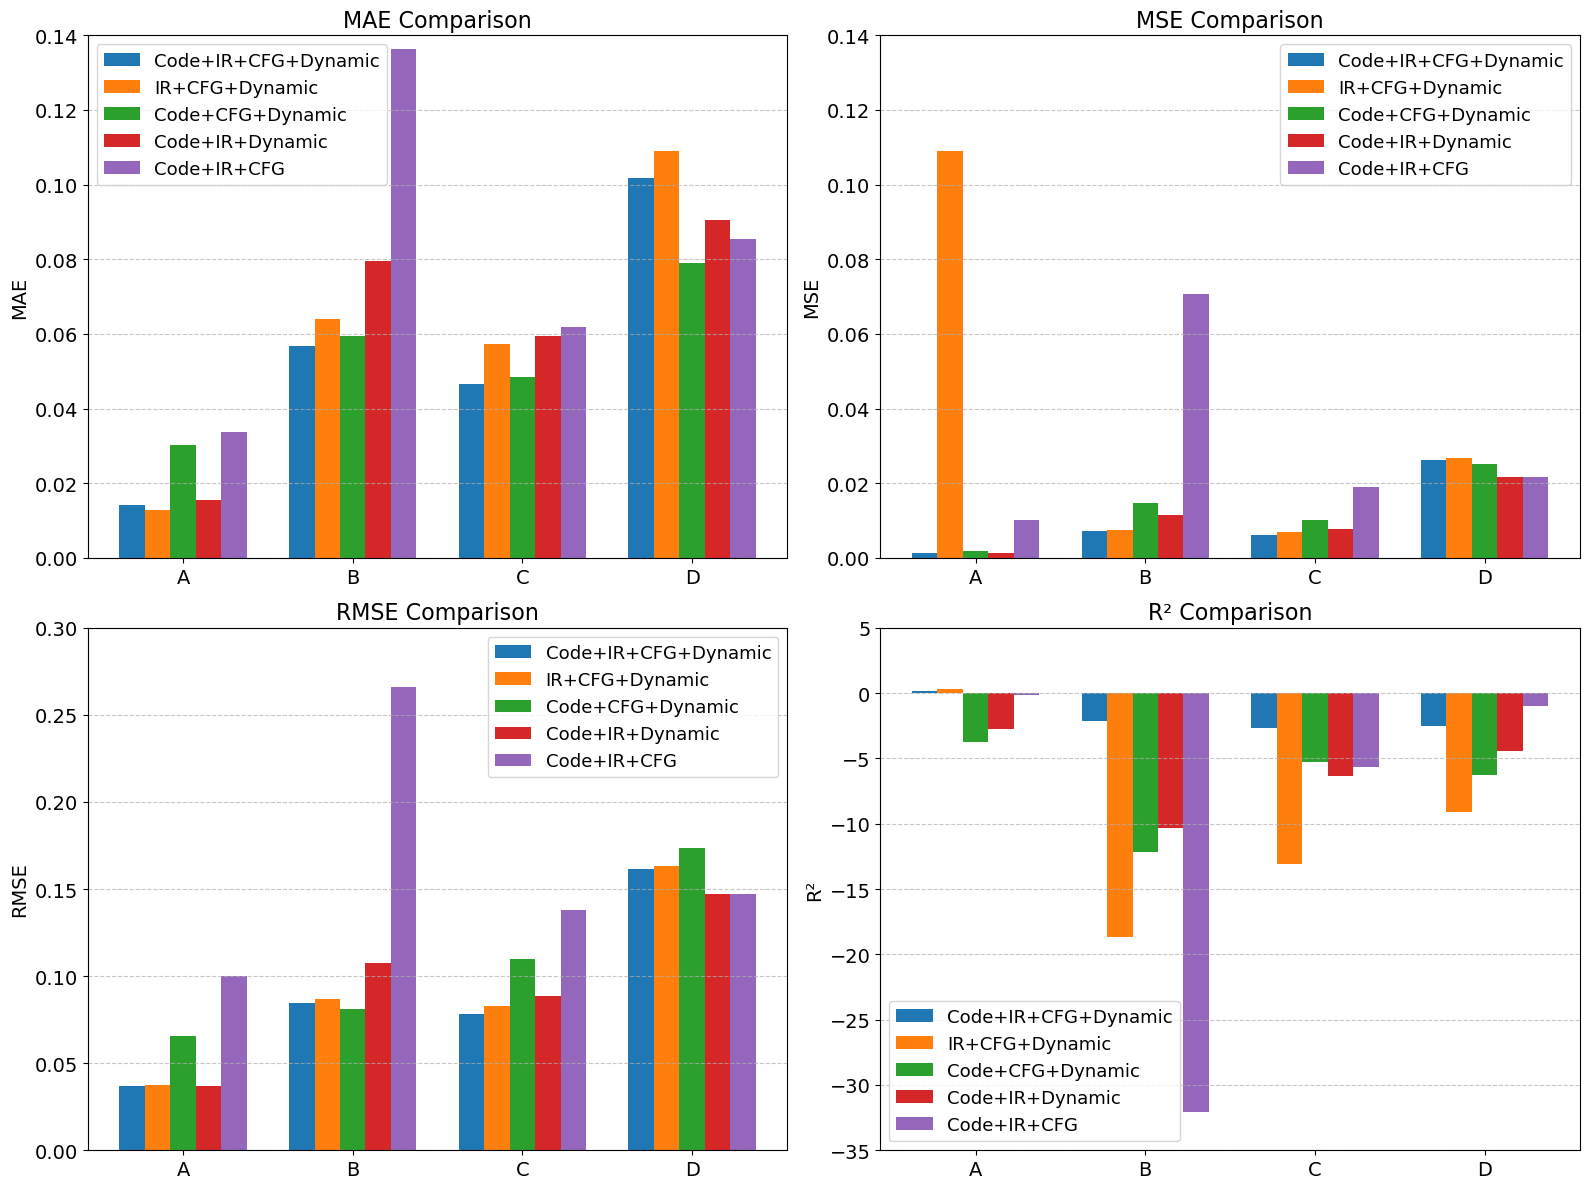

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 数据提取
data = {
    "Category": ["Code+IR+CFG+Dynamic", "IR+CFG+Dynamic", "Code+CFG+Dynamic", "Code+IR+Dynamic", "Code+IR+CFG"],
    "A_MAE": [0.0141, 0.0128, 0.0301, 0.0155, 0.0337],
    "B_MAE": [0.0568, 0.0640, 0.0594, 0.0794, 0.1363],
    "C_MAE": [0.0465, 0.0573, 0.0485, 0.0593, 0.0619],
    "D_MAE": [0.1019, 0.1089, 0.0789, 0.0906, 0.0853],
    "A_MSE": [0.0013, 0.1089, 0.0019, 0.0013, 0.0100],
    "B_MSE": [0.0072, 0.0075, 0.0147, 0.0115, 0.0707],
    "C_MSE": [0.0061, 0.0068, 0.0102, 0.0078, 0.0190],
    "D_MSE": [0.0261, 0.0267, 0.0250, 0.0216, 0.0216],
    "A_RMSE": [0.0367, 0.0372, 0.0654, 0.0367, 0.1000],
    "B_RMSE": [0.0848, 0.0866, 0.0813, 0.1073, 0.2660],
    "C_RMSE": [0.0781, 0.0826, 0.1097, 0.0884, 0.1378],
    "D_RMSE": [0.1616, 0.1633, 0.1735, 0.1469, 0.1470],
    "A_R²": [0.1999, 0.3409, -3.7243, -2.7241, -0.1780],
    "B_R²": [-2.1283, -18.7037, -12.1432, -10.3439, -32.0679],
    "C_R²": [-2.6591, -13.0496, -5.3014, -6.3234, -5.6578],
    "D_R²": [-2.5263, -9.0911, -6.2478, -4.4576, -1.0114]
}

df = pd.DataFrame(data)

# 绘制分组柱状图
categories = df["Category"]
metrics = ["MAE", "MSE", "RMSE", "R²"]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Define y-axis limits for each metric
y_limits = {
    "MAE": (0, 0.14),
    "MSE": (0, 0.14),
    "RMSE": (0, 0.3),
    "R²": (-35, 5)
}

for i, metric in enumerate(metrics):
    sub_data = df[[f"A_{metric}", f"B_{metric}", f"C_{metric}", f"D_{metric}"]].T
    sub_data.columns = categories
    x = np.arange(len(sub_data))  # A, B, C, D
    width = 0.15  # Column width

    for j, category in enumerate(categories):
        axes[i].bar(x + j * width, sub_data[category], width, label=category)

    axes[i].set_title(f"{metric} Comparison", fontsize=16)
    axes[i].set_ylabel(metric, fontsize=14)
    axes[i].set_xticks(x + width * (len(categories) - 1) / 2)
    axes[i].set_xticklabels(["A", "B", "C", "D"], fontsize=14)
    axes[i].legend(prop={'size': 13})
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

    # Set y-axis limits
    axes[i].set_ylim(y_limits[metric])

    # Increase font size for y-axis ticks
    axes[i].tick_params(axis='y', labelsize=14)
    # Increase font size for x-axis ticks
    axes[i].tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.savefig("png/data_scale_with_y_limits.png", dpi=300)  # 保存为 PNG 格式，分辨率为 300 DPI
plt.show()


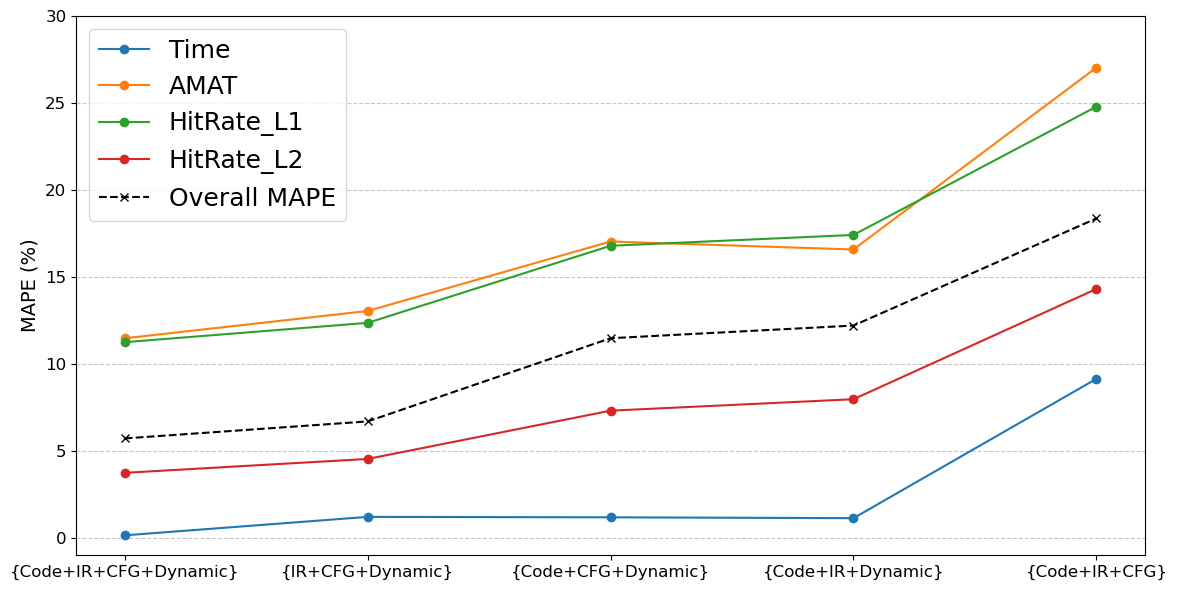

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载两个文件的数据
category_file = "category_metrics_results_kind.csv"
ablation_file = "result/ablation_model_results.csv"

category_df = pd.read_csv(category_file)
ablation_df = pd.read_csv(ablation_file)

# 提取需要的列
category_data = category_df[["Config", "Category", "MAPE"]]
ablation_data = ablation_df[["Config", "MAPE"]]

# 获取所有类别
categories = category_data["Category"].unique()

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每个类别的曲线
for category in categories:
    subset = category_data[category_data["Category"] == category]
    plt.plot(subset["Config"], subset["MAPE"], marker="o", label=f"{category}")

# 绘制 ablation_model_results.csv 的曲线
plt.plot(ablation_data["Config"], ablation_data["MAPE"], marker="x", linestyle="--", color="black", label="Overall MAPE")

# 设置图形标签和标题
plt.ylabel("MAPE (%)", fontsize=14)

# 设置 y 轴区间 (根据需要调整)
plt.ylim(-1, 30)  # 例如设置 y 轴范围从 0 到 100，适合 MAPE 的范围

# 设置坐标轴刻度字体大小
plt.xticks(fontsize=12)  # Set x-axis ticks font size
plt.yticks(fontsize=12)  # Set y-axis ticks font size

# 添加图例并调整字体大小
plt.legend(loc=0, prop={'size': 18})

# 添加网格线
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 调整布局并显示图形
plt.tight_layout()
plt.savefig("png/22_adjusted.png", dpi=300)  # 保存为 PNG 格式，分辨率为 300 DPI
plt.show()


测试数据输入规模不同时的预测准确性

In [42]:
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def restore_grd(grd_values):
    """
    恢复原始 grd 值。
    1. 逆 MinMaxScaler 归一化
    2. 逆 log1p 变换
    """
    # 逆 MinMaxScaler
    grd_rescaled = minmax_scaler.inverse_transform(grd_values.reshape(-1, 1))
    # 逆 log1p
    original_grd = np.expm1(grd_rescaled).flatten()  # 转为 1D 数组返回
    print("After expm1 transform:", original_grd[:5])
    return original_grd

def compute_log_bins(grd_values, num_bins=5):
    """
    根据转制后的 grd 字段自动生成对数量级区间。
    """
    min_value = max(np.min(grd_values), 1e-10)  # 避免 log(0)
    max_value = np.max(grd_values)

    print(min_value)
    print(max_value)
    # 使用对数生成区间（避免 log(0)，对 min_value 做偏移）
    log_min = np.floor(np.log10(min_value))
    log_max = np.ceil(np.log10(max_value))
    bins = np.logspace(log_min, log_max, num=num_bins)
    return bins

def test_model_per_grd_range(config, model_path, test_loader, device, grd_index, num_bins=5):
    """
    对单个配置的模型进行分区间的测试。
    """
    print(f"\nTesting with config: {config}")

    # 初始化模型
    model = AblationModelWithWeights(
        code_input_dim=768,
        dynamic_input_dim=16,
        gcn_hidden_dim=32,
        gcn_output_dim=16,
        embed_dim=32,
        **config
    ).to(device)

    # 加载模型参数
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")

    all_predictions = []
    all_labels = []
    all_grd_values = []

    # 模态处理逻辑
    with torch.no_grad():
        for code_batch, dynamic_batch, graph_batch, labels in test_loader:
            # 将标签加载到设备
            labels = labels.to(device)
            # 提取 grd 列
            grd_values = dynamic_batch[:, grd_index].cpu().numpy()
            all_grd_values.extend(grd_values)

            # Code 模态
            if config.get("use_code", True):
                code_data = code_batch.to(device)
            else:
                code_data = torch.zeros_like(code_batch).to(device)  # 使用零向量代替

            # dynamic 模态
            if config.get("use_dynamic", True):
                dynamic_data = dynamic_batch.to(device)
            else:
                dynamic_data = torch.zeros_like(dynamic_batch).to(device)  # 使用零向量代替

            # Graph 模态
            if config.get("use_graph", True):
                graph_data = graph_batch.to(device)
            else:
                # 使用空图代替 graph 模态
                graph_data = type(graph_batch)(
                    x=torch.zeros_like(graph_batch.x).to(device),
                    edge_index=torch.zeros_like(graph_batch.edge_index).to(device),
                    batch=torch.zeros_like(graph_batch.batch).to(device),
                )

            # 前向传播得到预测值
            outputs = model(code_data, dynamic_data, graph_data)

            # 收集预测值和真实值
            all_predictions.append(outputs.cpu())
            all_labels.append(labels.cpu())

    # 拼接所有的预测值和真实值
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_grd_values = np.array(all_grd_values)
    print("Original GRD values:", all_grd_values[:5])
    # 恢复原始 grd 值
    restored_grd = restore_grd(all_grd_values)

    print(f"Predictions shape: {all_predictions.shape}, Labels shape: {all_labels.shape}")
    print(f"Restored GRD shape: {restored_grd.shape}")

    # 自动生成对数量级区间
    bins = compute_log_bins(restored_grd, num_bins=num_bins)
    print(f"Auto-generated bins: {bins}")

    # 分区间测试
    results = {}
    for i in range(1, len(bins)):
        print(f"\nTesting for grd range: {bins[i-1]:.2f} to {bins[i]:.2f}")

        # 筛选当前区间的数据
        mask = (restored_grd >= bins[i-1]) & (restored_grd < bins[i])
        selected_indices = np.where(mask)[0]

        if len(selected_indices) == 0:
            print("No samples in this range.")
            continue

        # 提取当前区间的数据
        range_predictions = all_predictions[selected_indices]
        range_labels = all_labels[selected_indices]

        # 计算误差指标
        mae = mean_absolute_error(range_labels, range_predictions)
        mse = mean_squared_error(range_labels, range_predictions)
        rmse = mse ** 0.5
        r2 = r2_score(range_labels, range_predictions)

        print(f"Range {bins[i-1]:.2f} to {bins[i]:.2f}:")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

        results[f"{bins[i-1]:.2f} to {bins[i]:.2f}"] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R2": r2,
        }

    return results

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 配置不同的消融实验
configs = [
    {'use_code': True, 'use_dynamic': True, 'use_graph': True},  # 全部启用（Baseline）
    {'use_code': False, 'use_dynamic': True, 'use_graph': True},  # 去掉 Code 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': True},  # 去掉 dynamic 分支
    {'use_code': True, 'use_dynamic': True, 'use_graph': False},  # 去掉 Graph 分支
    {'use_code': True, 'use_dynamic': False, 'use_graph': False},  # 只使用 Code 分支
]

# 定义 grd 字段信息
grd_index = 0  # 假设 grd 是 dynamic 数据的第 0 列

# 测试所有配置
final_results = {}
for config in configs:
    model_load_path = f"model_{str(config)}.pth"  # 模型路径
    results = test_model_per_grd_range(config, model_load_path, test_loader, device, grd_index, num_bins=5)
    final_results[str(config)] = results

# 打印最终结果汇总
print("\nFinal Results Summary:")
for config, result in final_results.items():
    print(f"Config: {config}")
    for range_key, metrics in result.items():
        print(f"Input Size Range {range_key}:")
        print(f"MAE: {metrics['MAE']:.4f}, MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")
        print("-" * 50)



Testing with config: {'use_code': True, 'use_tabular': True, 'use_graph': True}
Model loaded from model_{'use_code': True, 'use_tabular': True, 'use_graph': True}.pth


/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Original GRD values: [0.26685414 0.26685414 0.26685414 0.26685414 0.26685414]
After expm1 transform: [255.99988 255.99988 255.99988 255.99988 255.99988]
Predictions shape: (10622, 4), Labels shape: (10622, 4)
Restored GRD shape: (10622,)
255.99988
268435460.0
Auto-generated bins: [1.00000000e+02 5.62341325e+03 3.16227766e+05 1.77827941e+07
 1.00000000e+09]

Testing for grd range: 100.00 to 5623.41
Range 100.00 to 5623.41:
Mean Absolute Error (MAE): 0.0141
Mean Squared Error (MSE): 0.0013
Root Mean Squared Error (RMSE): 0.0367
R² Score: 0.1999

Testing for grd range: 5623.41 to 316227.77
Range 5623.41 to 316227.77:
Mean Absolute Error (MAE): 0.0568
Mean Squared Error (MSE): 0.0072
Root Mean Squared Error (RMSE): 0.0848
R² Score: -2.1283

Testing for grd range: 316227.77 to 17782794.10
Range 316227.77 to 17782794.10:
Mean Absolute Error (MAE): 0.0465
Mean Squared Error (MSE): 0.0061
Root Mean Squared Error (RMSE): 0.0781
R² Score: -2.6591

Testing for grd range: 17782794.10 to 1000000000

/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Original GRD values: [0.26685414 0.26685414 0.26685414 0.26685414 0.26685414]
After expm1 transform: [255.99988 255.99988 255.99988 255.99988 255.99988]
Predictions shape: (10622, 4), Labels shape: (10622, 4)
Restored GRD shape: (10622,)
255.99988
268435460.0
Auto-generated bins: [1.00000000e+02 5.62341325e+03 3.16227766e+05 1.77827941e+07
 1.00000000e+09]

Testing for grd range: 100.00 to 5623.41
Range 100.00 to 5623.41:
Mean Absolute Error (MAE): 0.0128
Mean Squared Error (MSE): 0.0014
Root Mean Squared Error (RMSE): 0.0372
R² Score: 0.3409

Testing for grd range: 5623.41 to 316227.77
Range 5623.41 to 316227.77:
Mean Absolute Error (MAE): 0.0640
Mean Squared Error (MSE): 0.0075
Root Mean Squared Error (RMSE): 0.0866
R² Score: -18.7037

Testing for grd range: 316227.77 to 17782794.10
Range 316227.77 to 17782794.10:
Mean Absolute Error (MAE): 0.0573
Mean Squared Error (MSE): 0.0068
Root Mean Squared Error (RMSE): 0.0826
R² Score: -13.0496

Testing for grd range: 17782794.10 to 10000000

/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Original GRD values: [0.26685414 0.26685414 0.26685414 0.26685414 0.26685414]
After expm1 transform: [255.99988 255.99988 255.99988 255.99988 255.99988]
Predictions shape: (10622, 4), Labels shape: (10622, 4)
Restored GRD shape: (10622,)
255.99988
268435460.0
Auto-generated bins: [1.00000000e+02 5.62341325e+03 3.16227766e+05 1.77827941e+07
 1.00000000e+09]

Testing for grd range: 100.00 to 5623.41
Range 100.00 to 5623.41:
Mean Absolute Error (MAE): 0.0337
Mean Squared Error (MSE): 0.0100
Root Mean Squared Error (RMSE): 0.1000
R² Score: -0.1780

Testing for grd range: 5623.41 to 316227.77
Range 5623.41 to 316227.77:
Mean Absolute Error (MAE): 0.1363
Mean Squared Error (MSE): 0.0707
Root Mean Squared Error (RMSE): 0.2660
R² Score: -32.0679

Testing for grd range: 316227.77 to 17782794.10
Range 316227.77 to 17782794.10:
Mean Absolute Error (MAE): 0.0619
Mean Squared Error (MSE): 0.0190
Root Mean Squared Error (RMSE): 0.1378
R² Score: -5.6578

Testing for grd range: 17782794.10 to 10000000

/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Original GRD values: [0.26685414 0.26685414 0.26685414 0.26685414 0.26685414]
After expm1 transform: [255.99988 255.99988 255.99988 255.99988 255.99988]
Predictions shape: (10622, 4), Labels shape: (10622, 4)
Restored GRD shape: (10622,)
255.99988
268435460.0
Auto-generated bins: [1.00000000e+02 5.62341325e+03 3.16227766e+05 1.77827941e+07
 1.00000000e+09]

Testing for grd range: 100.00 to 5623.41
Range 100.00 to 5623.41:
Mean Absolute Error (MAE): 0.0155
Mean Squared Error (MSE): 0.0013
Root Mean Squared Error (RMSE): 0.0367
R² Score: -2.7241

Testing for grd range: 5623.41 to 316227.77
Range 5623.41 to 316227.77:
Mean Absolute Error (MAE): 0.0794
Mean Squared Error (MSE): 0.0115
Root Mean Squared Error (RMSE): 0.1073
R² Score: -10.3439

Testing for grd range: 316227.77 to 17782794.10
Range 316227.77 to 17782794.10:
Mean Absolute Error (MAE): 0.0593
Mean Squared Error (MSE): 0.0078
Root Mean Squared Error (RMSE): 0.0884
R² Score: -6.3234

Testing for grd range: 17782794.10 to 10000000

/tmp/ipykernel_61495/259594654.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dynamic_data = torch.tensor(self.dynamic_features[idx], dtype=torch.float)


Original GRD values: [0.26685414 0.26685414 0.26685414 0.26685414 0.26685414]
After expm1 transform: [255.99988 255.99988 255.99988 255.99988 255.99988]
Predictions shape: (10622, 4), Labels shape: (10622, 4)
Restored GRD shape: (10622,)
255.99988
268435460.0
Auto-generated bins: [1.00000000e+02 5.62341325e+03 3.16227766e+05 1.77827941e+07
 1.00000000e+09]

Testing for grd range: 100.00 to 5623.41
Range 100.00 to 5623.41:
Mean Absolute Error (MAE): 0.0376
Mean Squared Error (MSE): 0.0107
Root Mean Squared Error (RMSE): 0.1034
R² Score: -0.2388

Testing for grd range: 5623.41 to 316227.77
Range 5623.41 to 316227.77:
Mean Absolute Error (MAE): 0.2889
Mean Squared Error (MSE): 0.2160
Root Mean Squared Error (RMSE): 0.4648
R² Score: -79.5929

Testing for grd range: 316227.77 to 17782794.10
Range 316227.77 to 17782794.10:
Mean Absolute Error (MAE): 0.2752
Mean Squared Error (MSE): 0.2176
Root Mean Squared Error (RMSE): 0.4664
R² Score: -58.8061

Testing for grd range: 17782794.10 to 1000000